# Data split for the 4-fold CV

---

This notebook can be used to generate data splits for the screening data to allow for parallel computing of the screens.

---

## 0. Environmental setup

In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (
    StratifiedGroupKFold,
    GroupShuffleSplit,
    LeaveOneGroupOut,
)
import os
from imblearn.under_sampling import RandomUnderSampler
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [148]:
def get_loto_data_splits(
    data,
    label_col,
    target_list,
    group_col,
    random_state=1234,
    val_size=0.2,
    test_size=0.2,
    sample_limit=None,
):
    label_data = data.loc[data.loc[:, label_col].isin(target_list), :]

    loto_data = {"train": [], "val": [], "test": [], "target": [], "name": []}

    for target in tqdm(target_list):
        loto_data["target"].append(
            label_data.loc[label_data.loc[:, label_col] == target]
        )
        train_val_test_data = label_data.loc[label_data.loc[:, label_col] != target]
        loto_data["name"].append(target)

        features = np.array(list(range(len(train_val_test_data)))).reshape(-1, 1)
        train_val_test_labels = np.array(train_val_test_data.loc[:, label_col])
        train_val_test_groups = np.array(train_val_test_data.loc[:, group_col])

        if "EMPTY" in np.unique(train_val_test_labels):
            idc = np.array(list(range(len(features)))).reshape(-1, 1)
            sample_count_dict = dict(Counter(train_val_test_labels))
            sample_count_dict["EMPTY"] = 0
            if sample_limit is not None:
                for k, v in sample_count_dict.items():
                    sample_count_dict[k] = min(v, sample_limit)
            sample_count_dict["EMPTY"] = np.max(list(sample_count_dict.values()))
            idc, _ = RandomUnderSampler(
                sampling_strategy=sample_count_dict, random_state=random_state
            ).fit_resample(idc, train_val_test_labels)
            train_val_test_data = train_val_test_data.iloc[idc.flatten(), :]
            train_val_test_labels = train_val_test_labels[idc.flatten()]
            train_val_test_groups = train_val_test_groups[idc.flatten()]

        train_index, test_index = next(
            StratifiedGroupKFold(n_splits=int(1.0 / test_size)).split(
                train_val_test_data, train_val_test_labels, groups=train_val_test_groups
            )
        )

        train_val_data = train_val_test_data.iloc[train_index]
        train_val_labels = train_val_test_labels[train_index]
        train_val_groups = train_val_test_groups[train_index]

        train_index, val_index = next(
            StratifiedGroupKFold(n_splits=int((1.0 - test_size) / val_size)).split(
                train_val_data, train_val_labels, groups=train_val_groups
            )
        )
        train_data = train_val_data.iloc[train_index]
        val_data = train_val_data.iloc[val_index]
        test_data = train_val_test_data.iloc[test_index]

        loto_data["train"].append(train_data)
        loto_data["val"].append(val_data)
        loto_data["test"].append(test_data)

    return loto_data

<IPython.core.display.Javascript object>

---
## 1. Read in data

To start we will read in the whole metadata set.

In [104]:
md = pd.read_csv(
    "../../../data/experiments/rohban/images/preprocessing/full_pipeline/padded_nuclei_metadata.csv.gz",
    index_col=0,
)
md.head()

,plate,well,image_file,gene_id,gene_symbol,is_landmark,allele,expr_vec,toxicity,ie_blast,...,minor_axis_length,major_axis_length,aspect_ratio,aspect_ratio_cluster,nuclei_count_image,slide_image_name,aspect_ratio_cluster_ratio,centroid_0,centroid_1,allele_symbol
0,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,NaN,0.91,...,15.474579,35.755476,0.432789,1,53,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,0.528302,17.675294,19.835294,EIF4E_WT.2
1,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,NaN,0.91,...,16.074259,48.342010,0.332511,1,53,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,0.528302,28.882645,273.150413,EIF4E_WT.2
2,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,NaN,0.91,...,24.256958,35.030138,0.692460,0,53,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,0.528302,149.476762,1002.848576,EIF4E_WT.2
3,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,NaN,0.91,...,27.689881,51.502812,0.537638,1,53,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,0.528302,250.939748,108.973921,EIF4E_WT.2
4,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,1977.0,EIF4E,0.0,WT.2,pLX304,NaN,0.91,...,26.587002,32.592086,0.815750,0,53,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,0.528302,252.834328,913.795522,EIF4E_WT.2


<IPython.core.display.Javascript object>

In [105]:
spec_results = pd.read_csv(
    "../../../data/experiments/rohban/images/screen/nuclei_region/specificity_screen_results_cv.csv",
    index_col=0,
)
spec_results = spec_results.loc[spec_results["selected"]]
spec_orf_targets = set(spec_results.index)

<IPython.core.display.Javascript object>

---

## 2. LeaveOneTargetOut split

We will now split the data in a leave-one-target out scheme, where we keep 20% of all nuclei from the training set in each fold for validation. Note that we will split the data such that all nuclei from the same patch image will be in either the validation or the training set. We additionally downsample the negative control condition to the maximum of the number of nuclei for a given condition in the training set to avoid severe imbalance.

In [116]:
output_dir = "../../../data/experiments/rohban/images/preprocessing"
os.makedirs(output_dir, exist_ok=True)

<IPython.core.display.Javascript object>

In [115]:
label_col = "gene_symbol"
group_col = "slide_image_name"
random_state = 1234

<IPython.core.display.Javascript object>

In [149]:
target_list = sorted(list(spec_orf_targets) + ["EMPTY"])
print(target_list)
loto_data = get_loto_data_splits(
    data=md,
    label_col=label_col,
    target_list=target_list,
    group_col=group_col,
    random_state=random_state,
)

['AKT1S1', 'ATF4', 'BAX', 'BCL2L11', 'BRAF', 'CASP8', 'CDC42', 'CDKN1A', 'CEBPA', 'CREB1', 'CXXC4', 'DIABLO', 'E2F1', 'ELK1', 'EMPTY', 'ERG', 'FGFR3', 'FOXO1', 'GLI1', 'HRAS', 'IRAK4', 'JUN', 'MAP2K3', 'MAP3K2', 'MAP3K5', 'MAP3K9', 'MAPK7', 'MOS', 'MYD88', 'PIK3R2', 'PRKACA', 'PRKCE', 'RAF1', 'RELB', 'RHOA', 'SMAD4', 'SMO', 'SRC', 'SREBF1', 'TRAF2', 'TSC2', 'WWTR1']


100%|██████████| 42/42 [02:14<00:00,  3.21s/it]


<IPython.core.display.Javascript object>

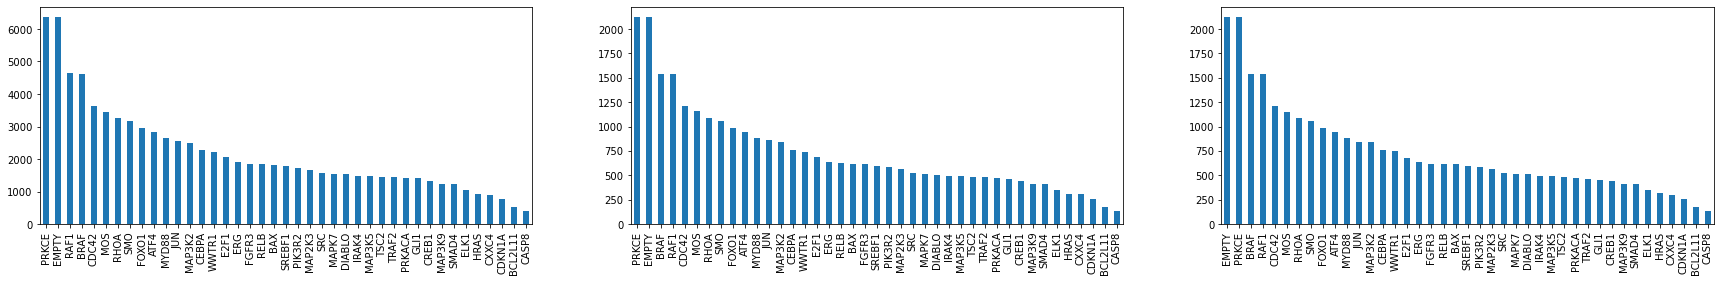

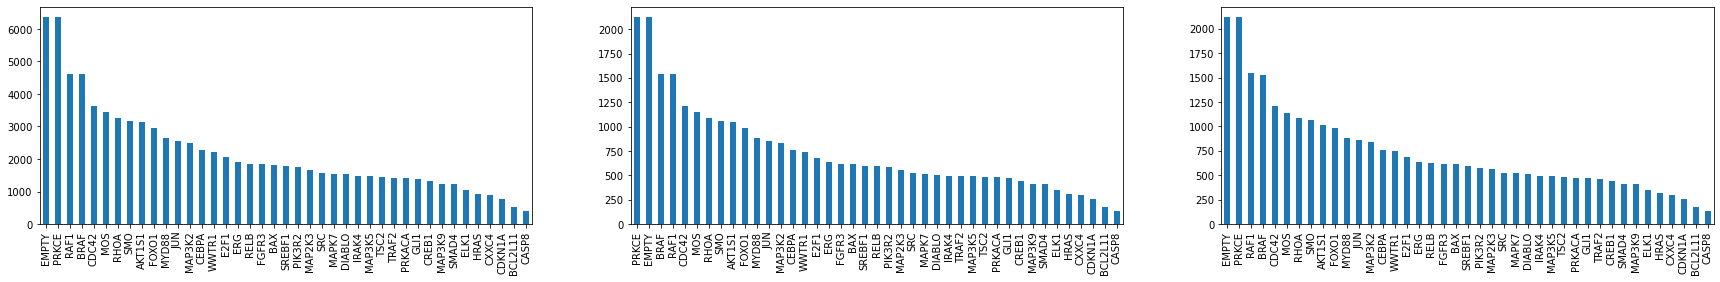

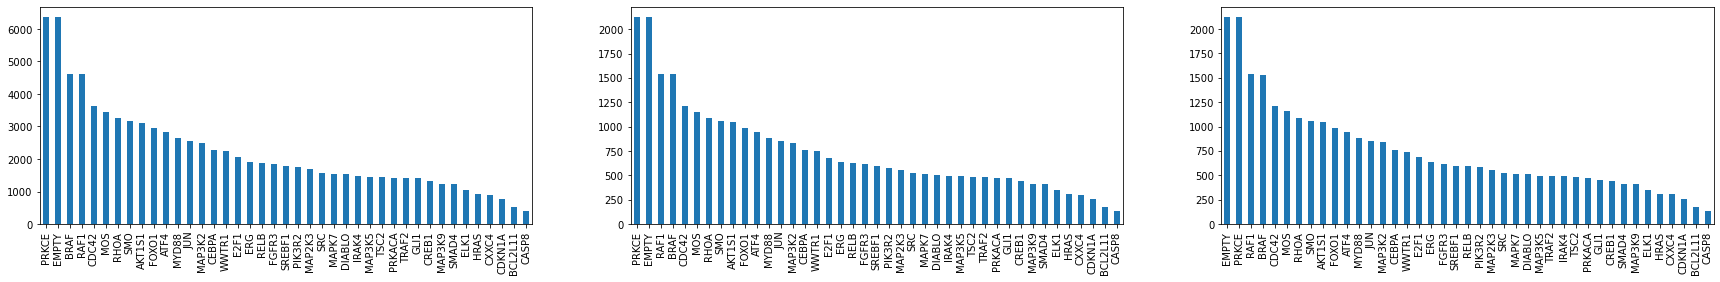

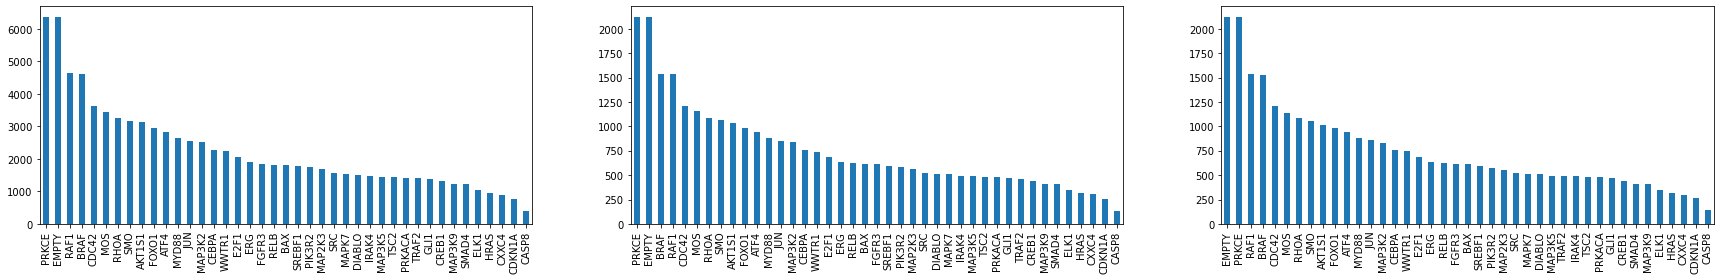

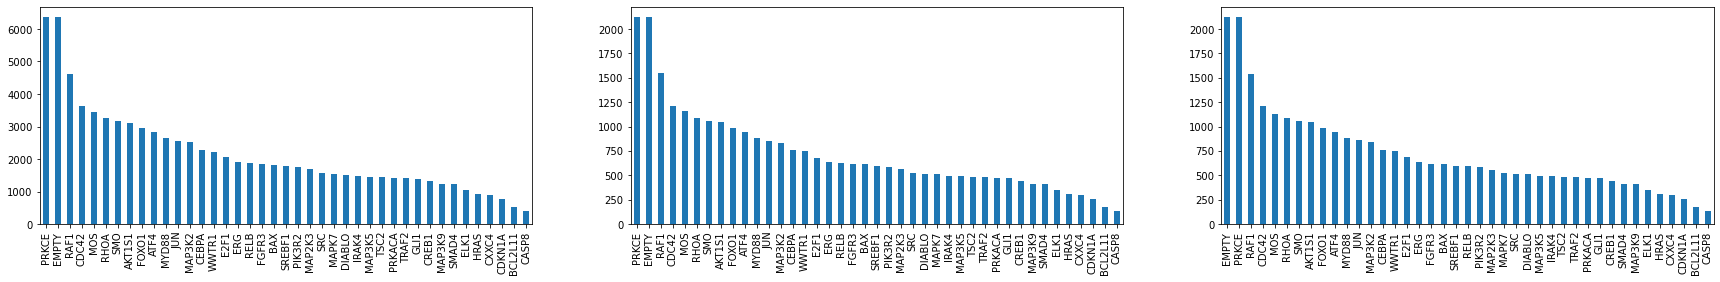

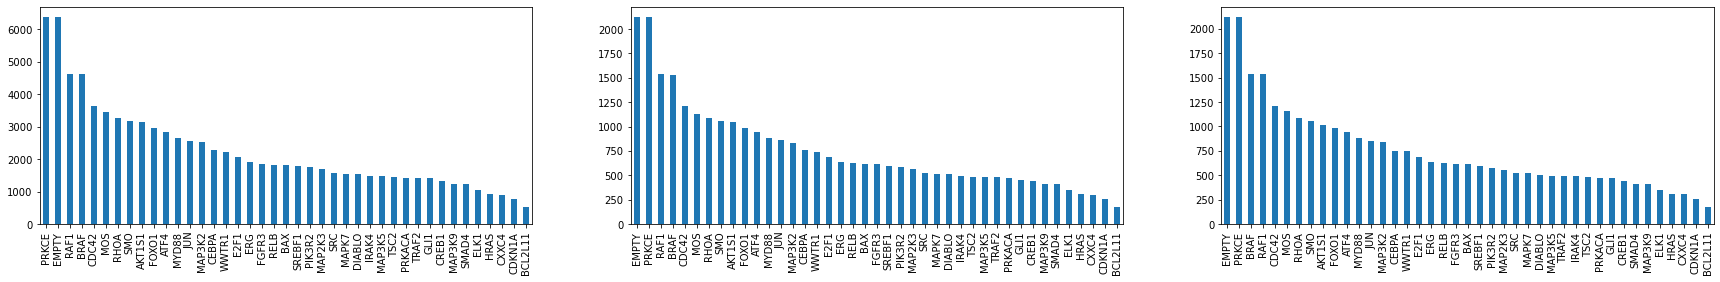

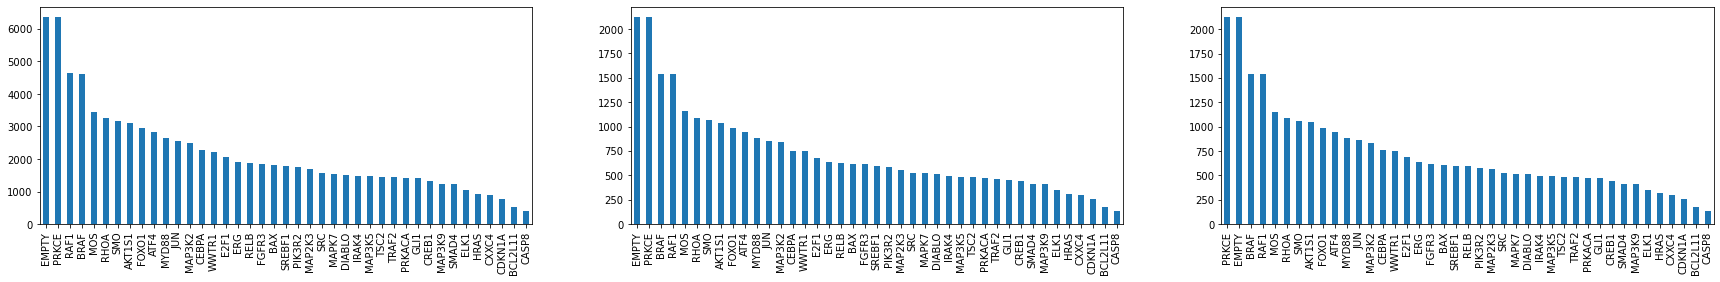

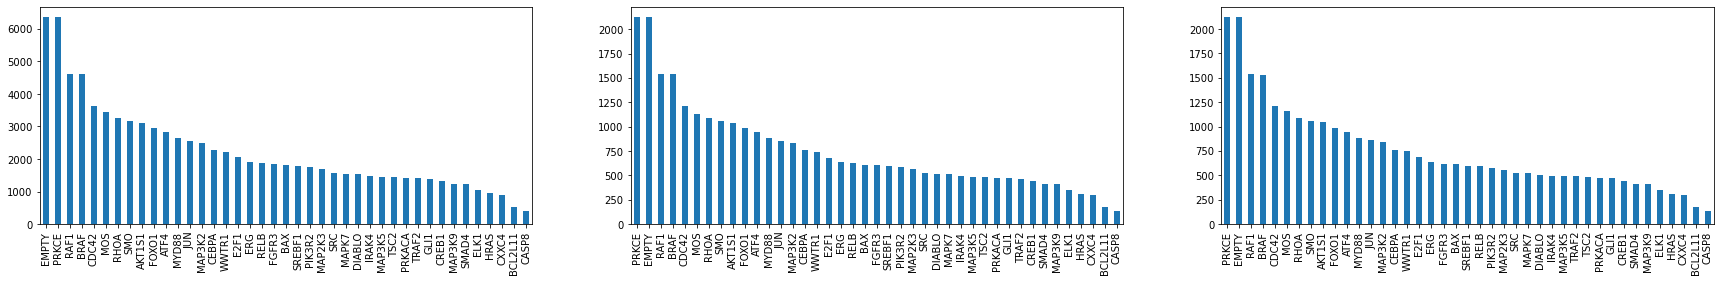

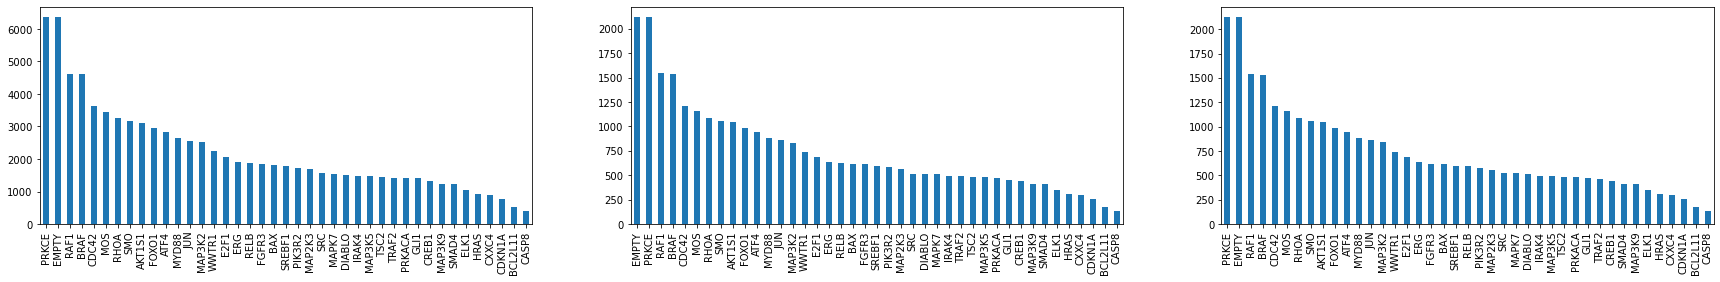

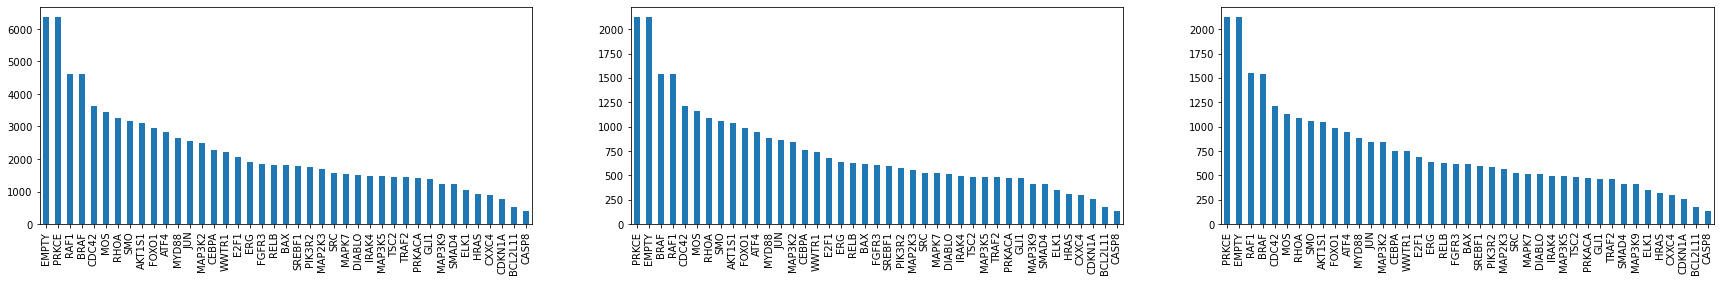

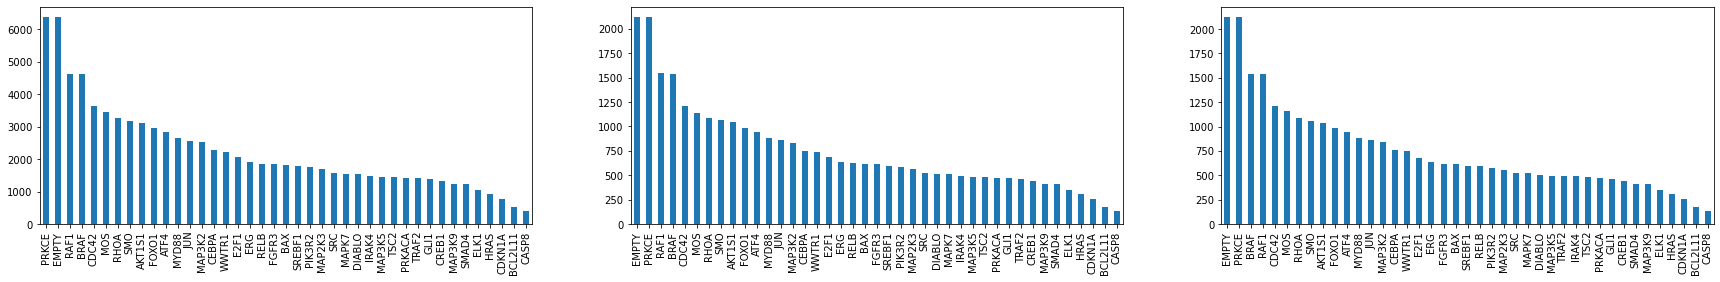

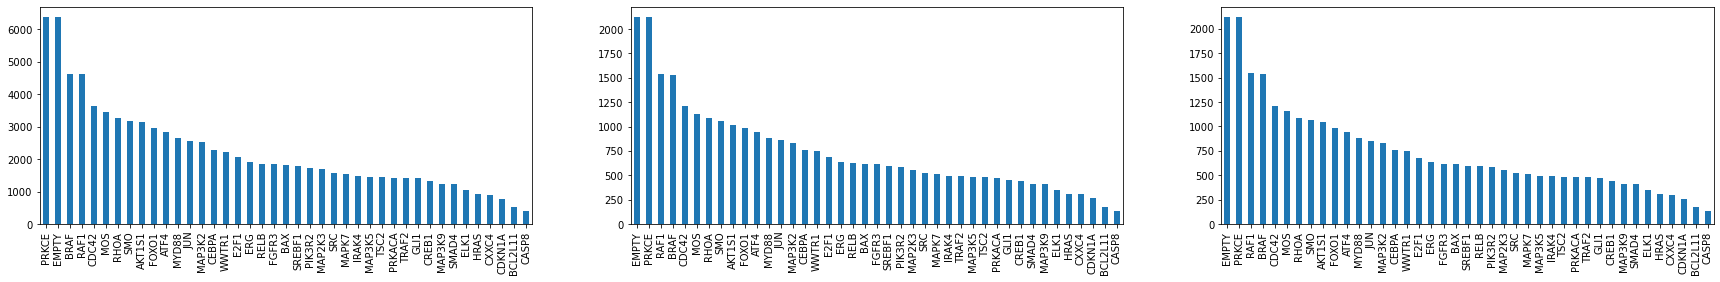

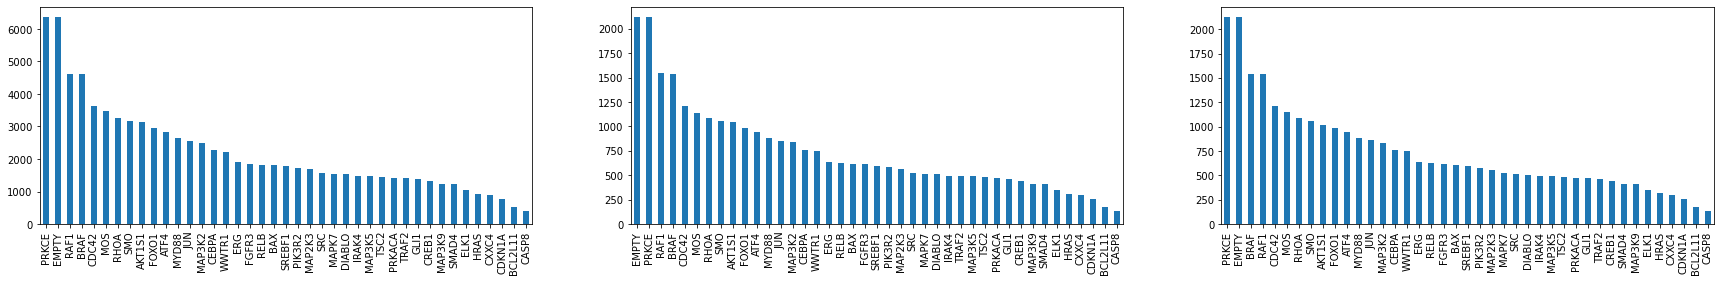

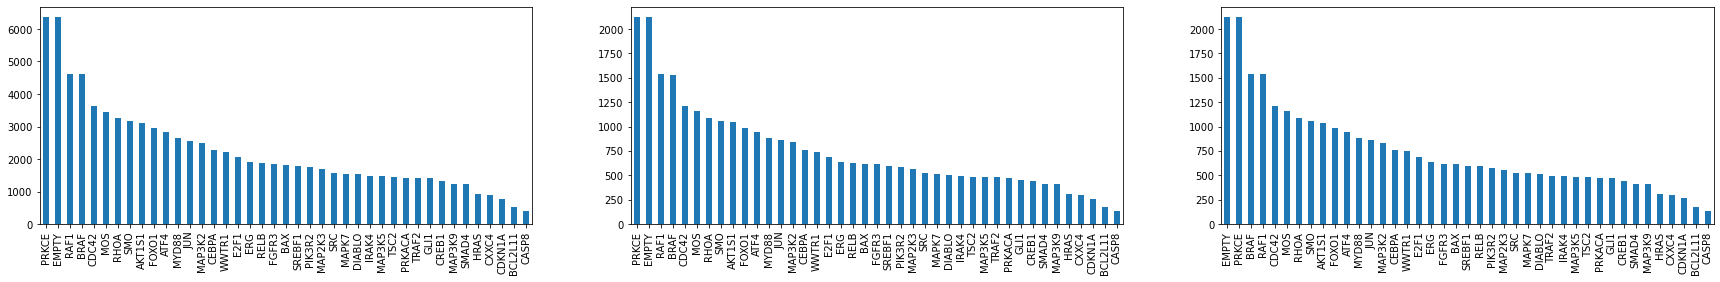

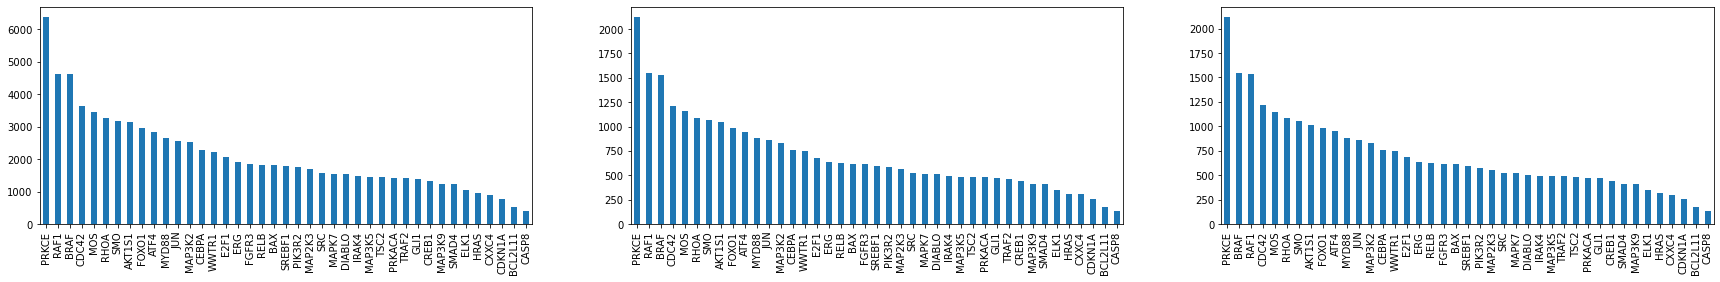

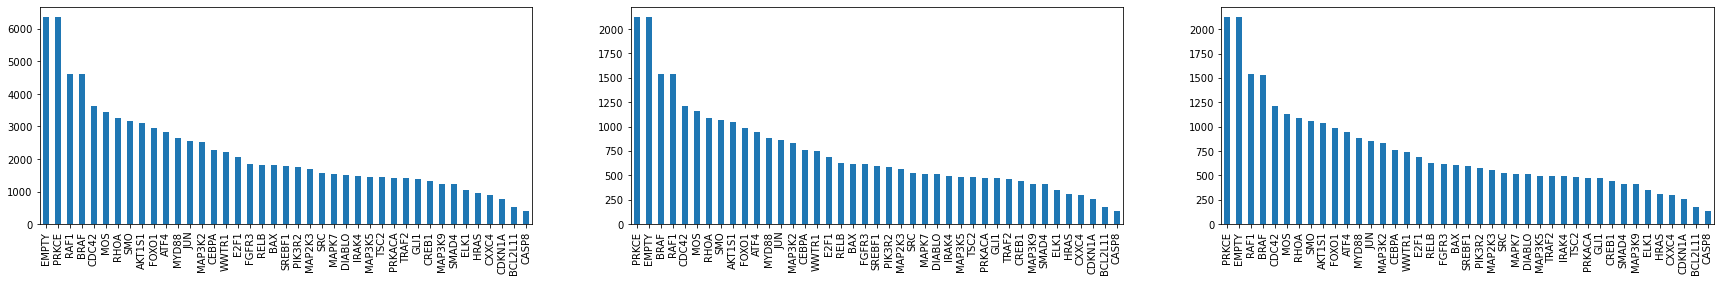

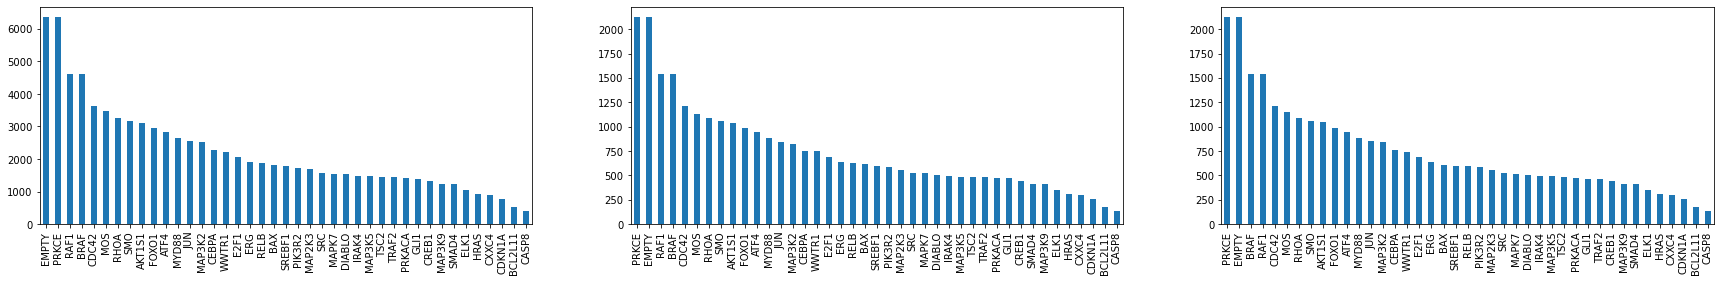

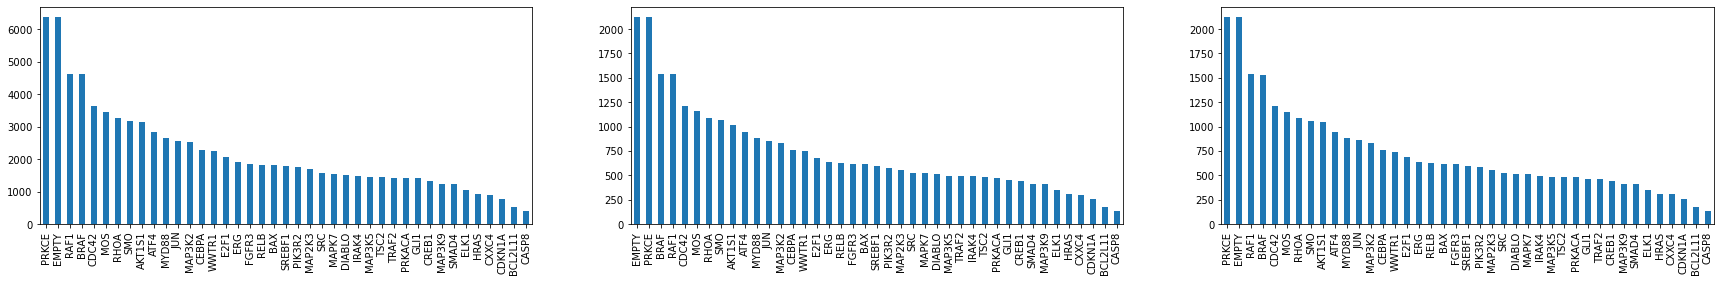

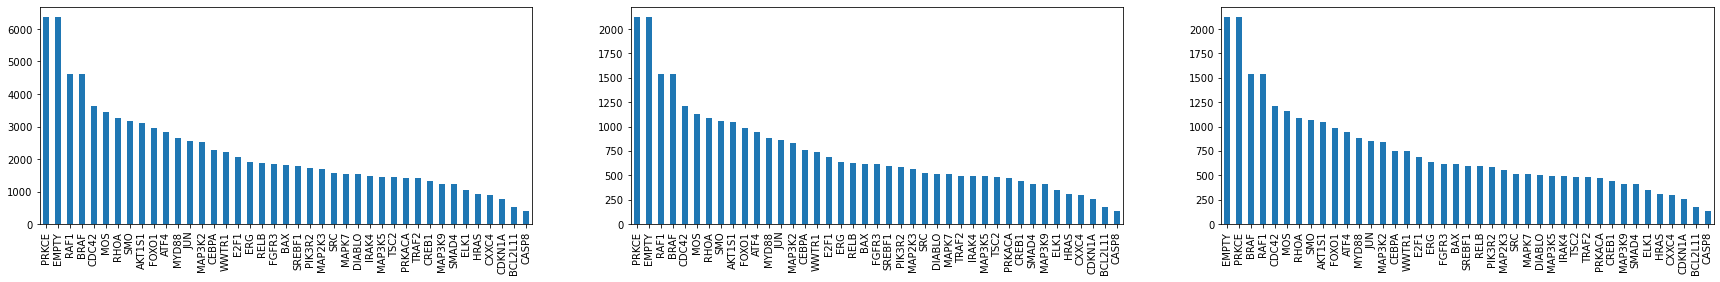

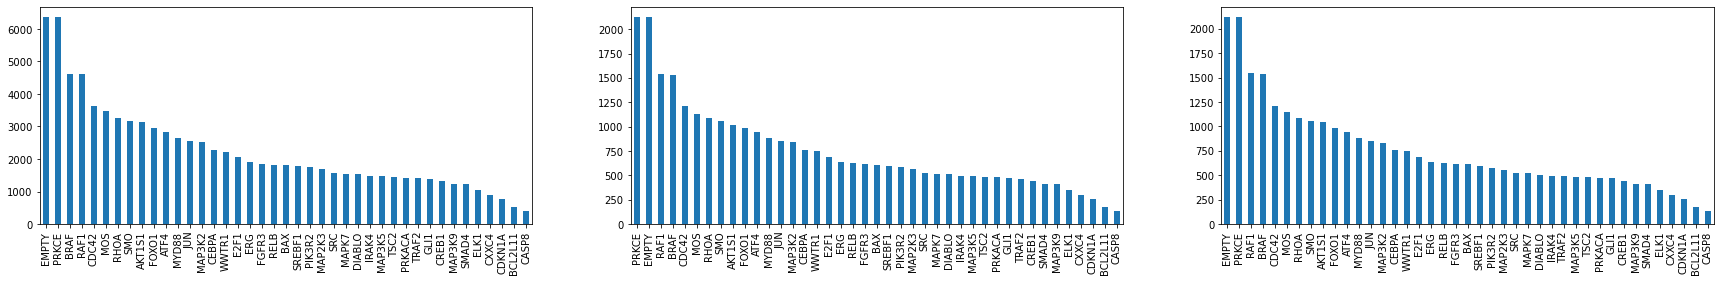

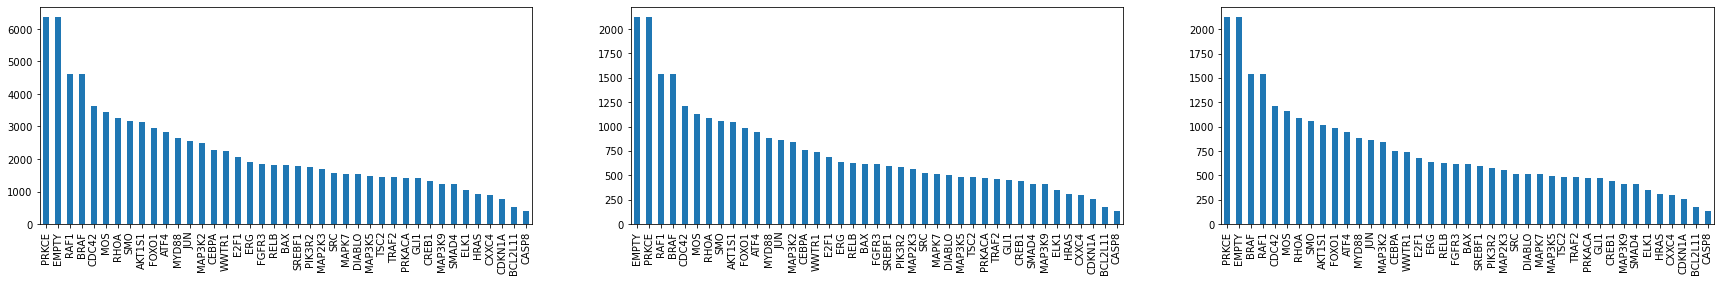

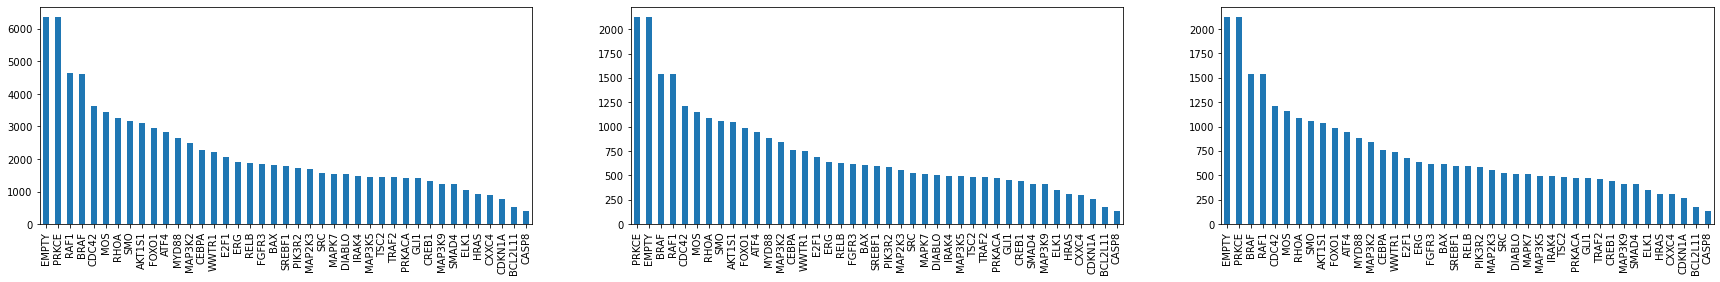

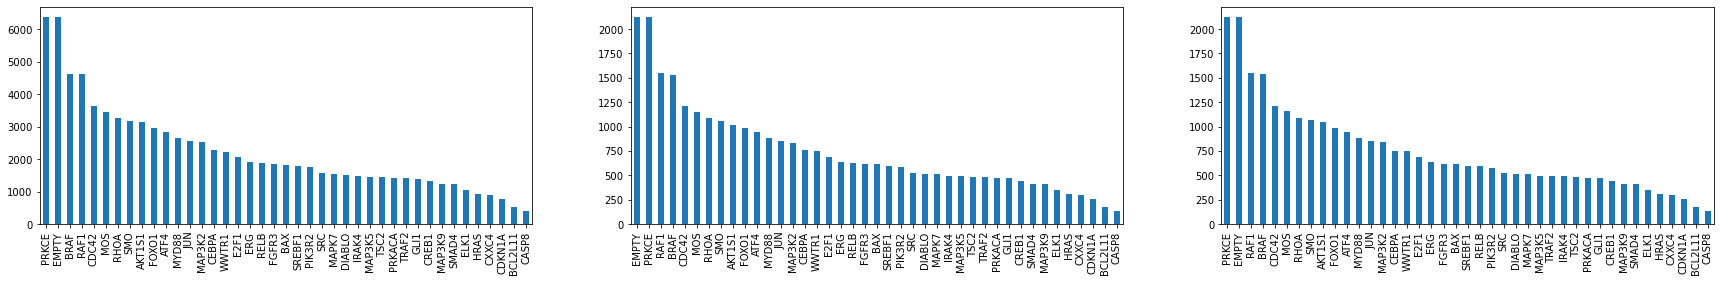

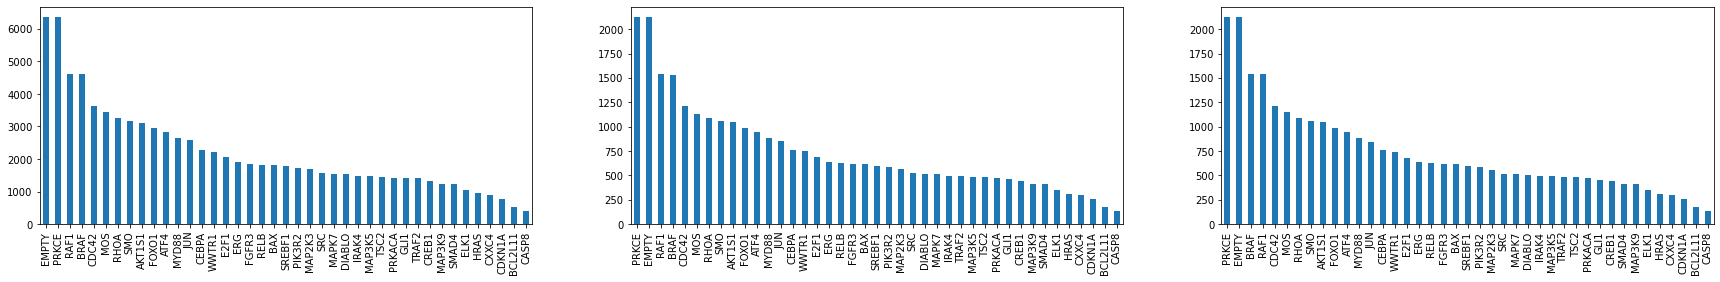

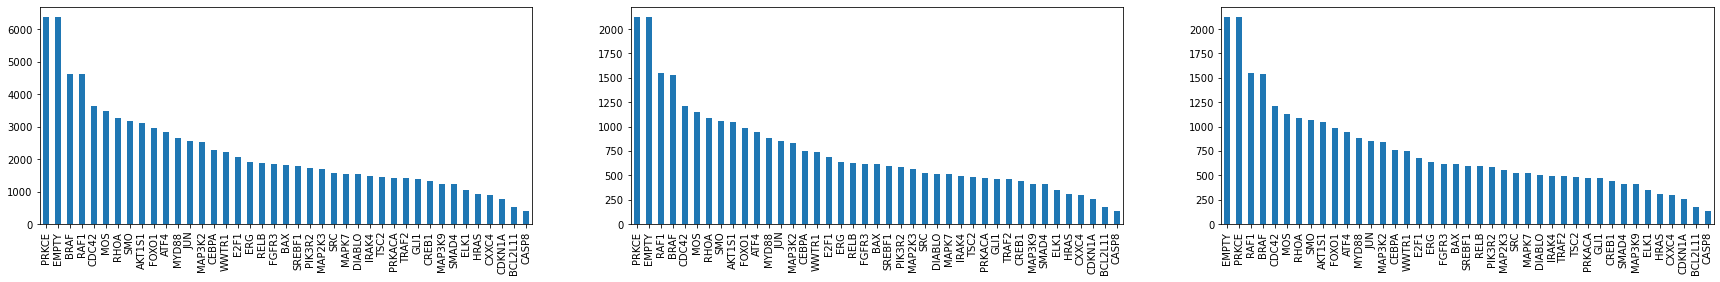

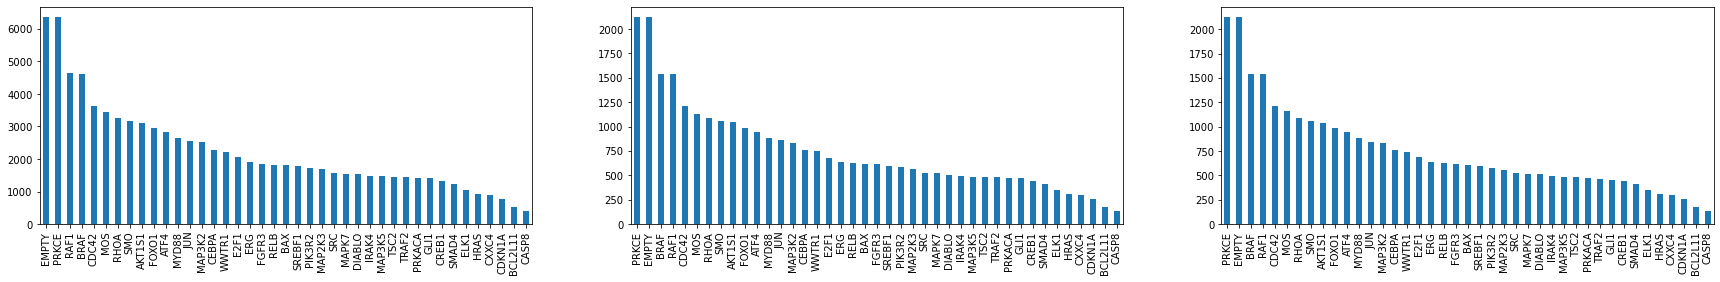

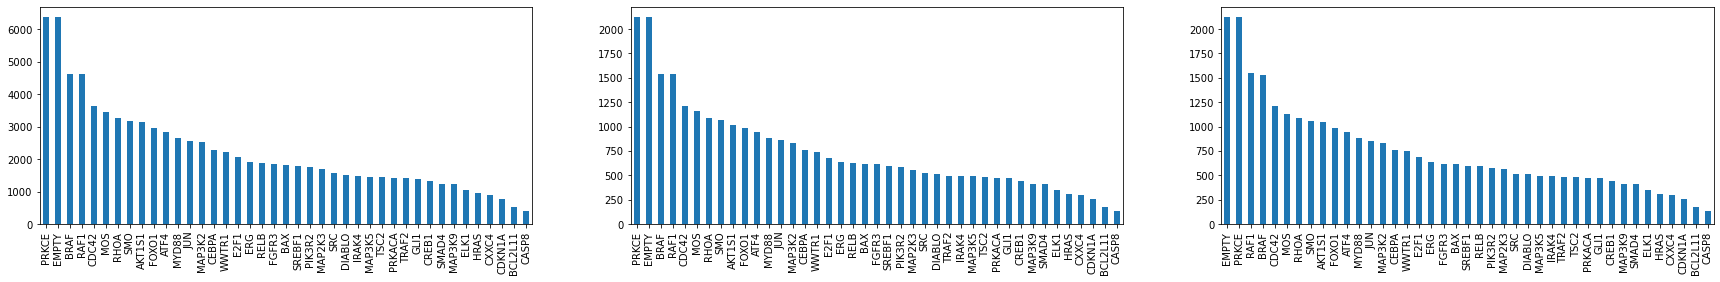

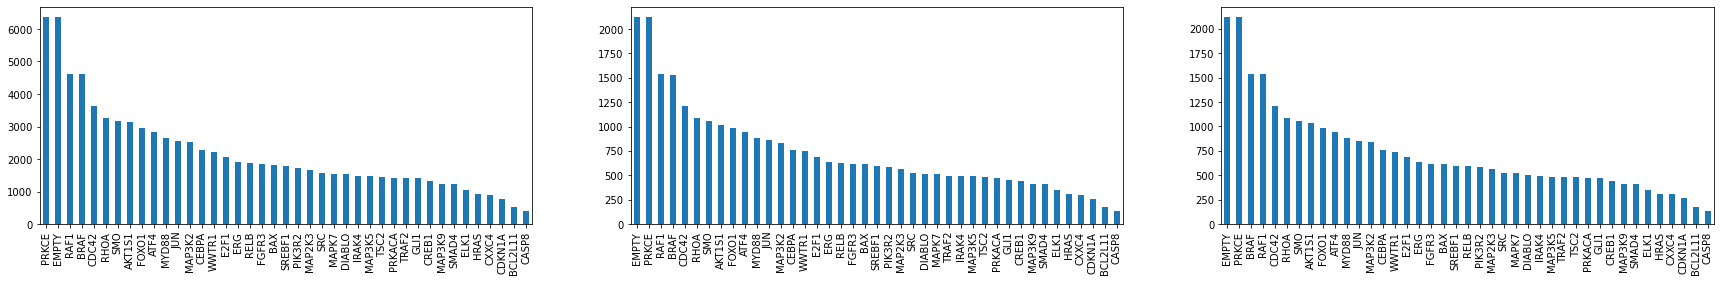

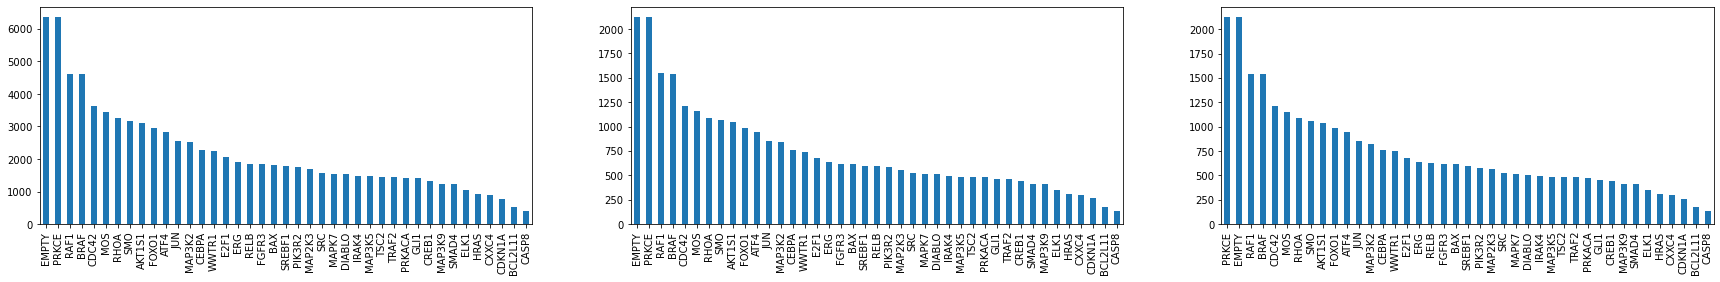

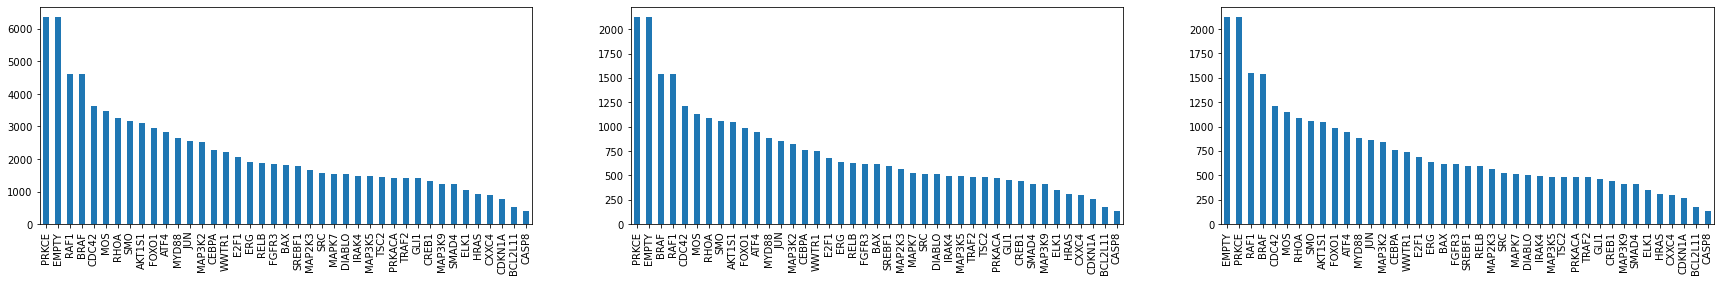

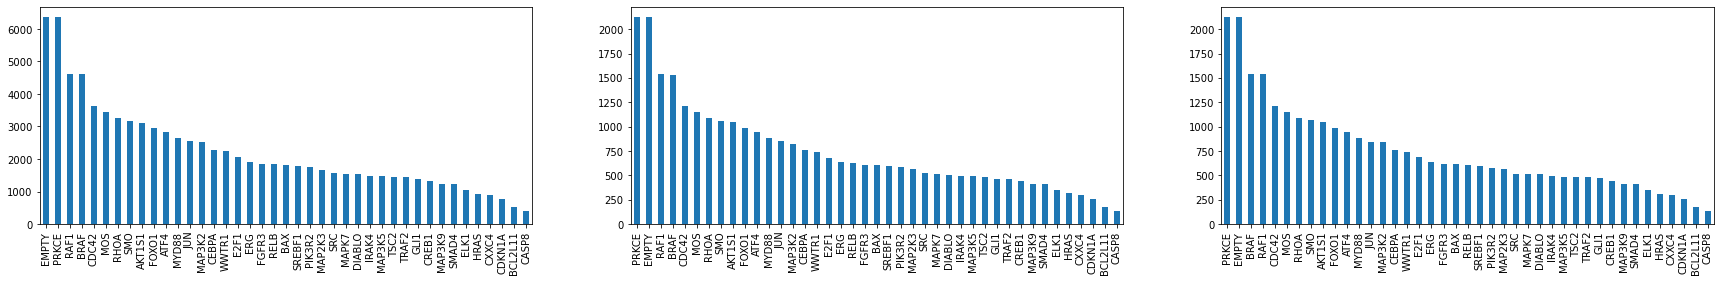

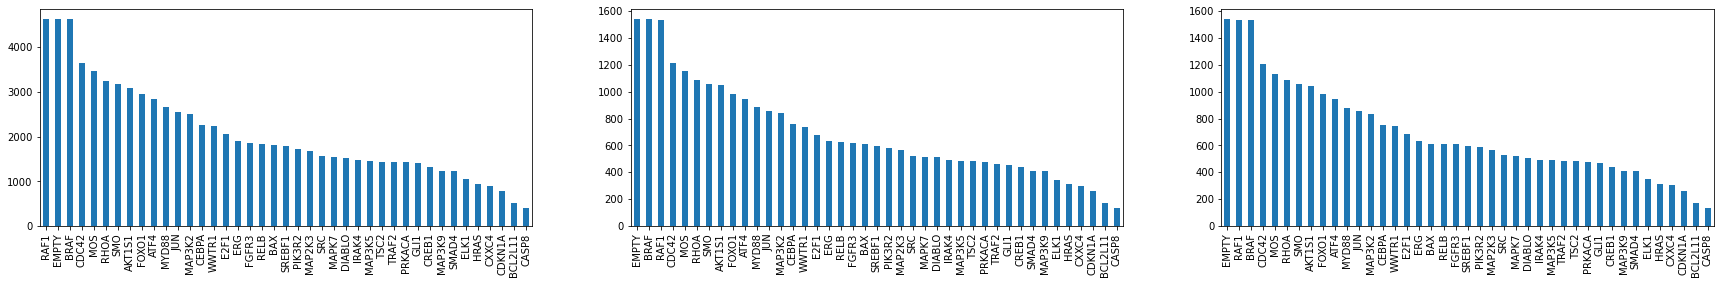

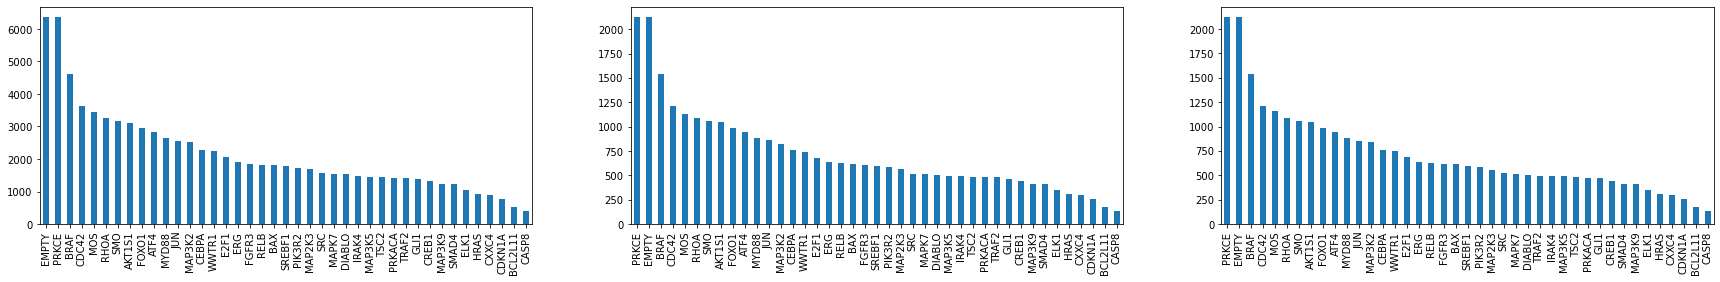

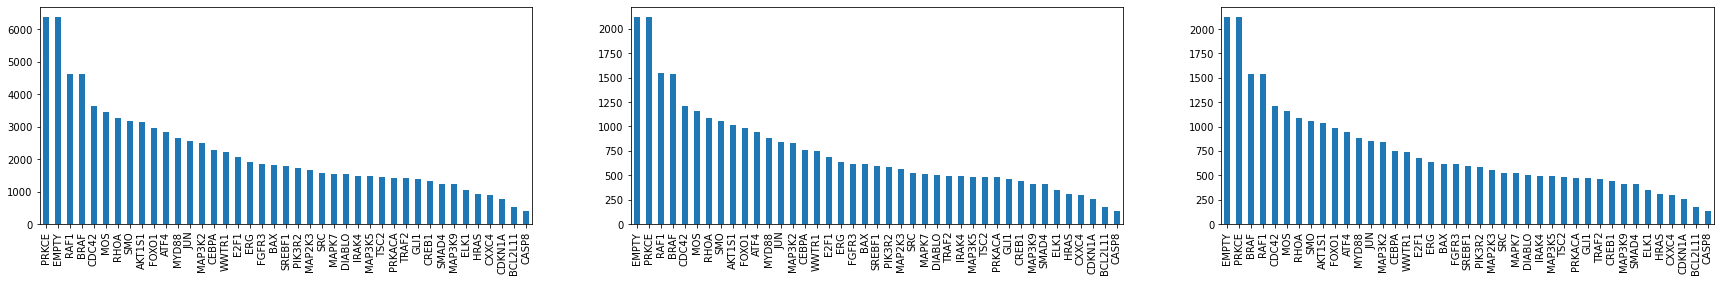

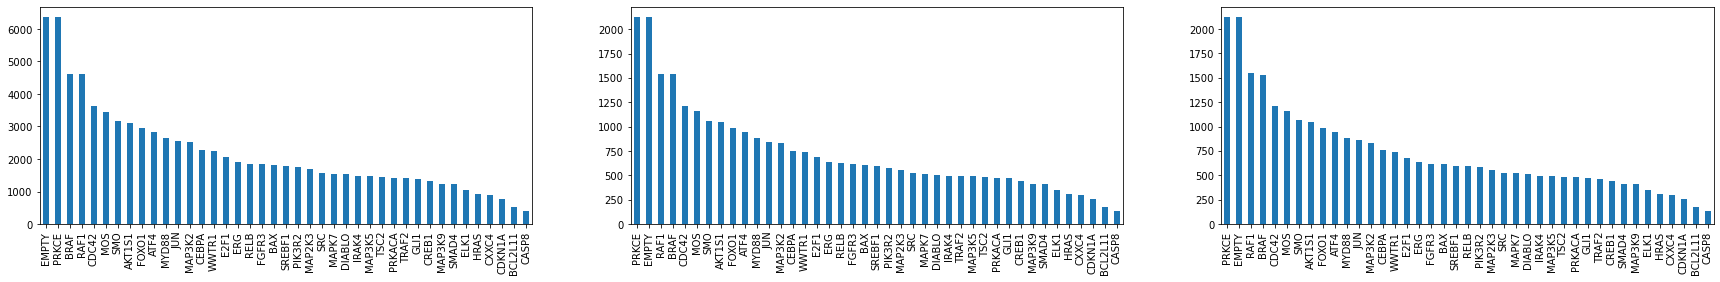

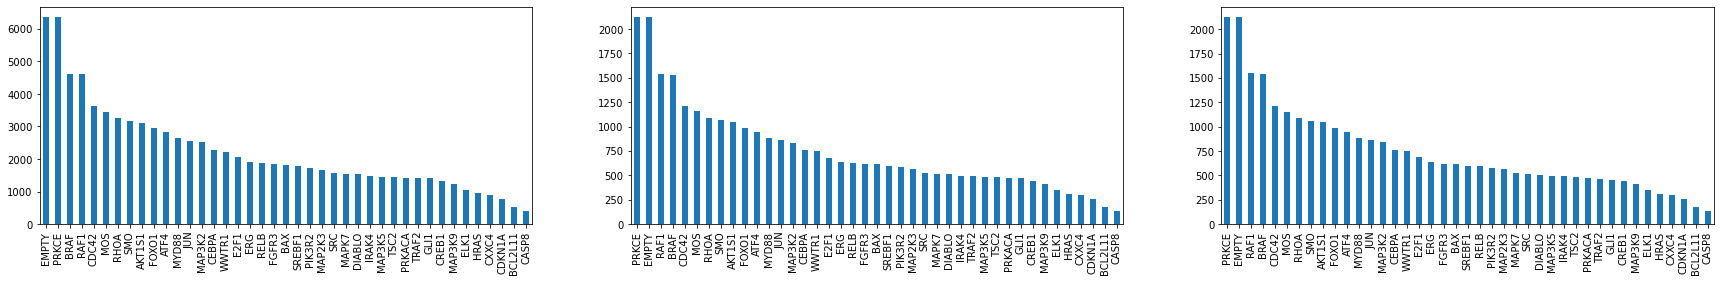

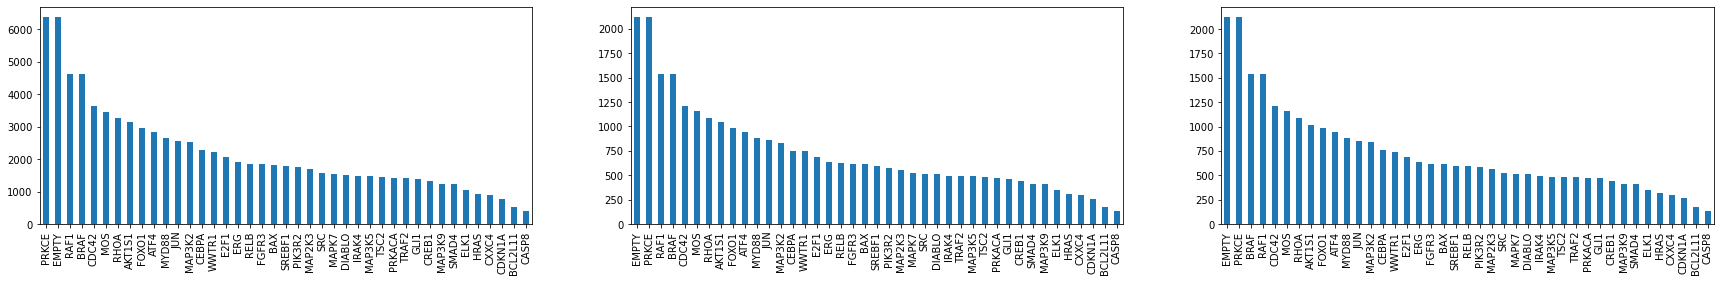

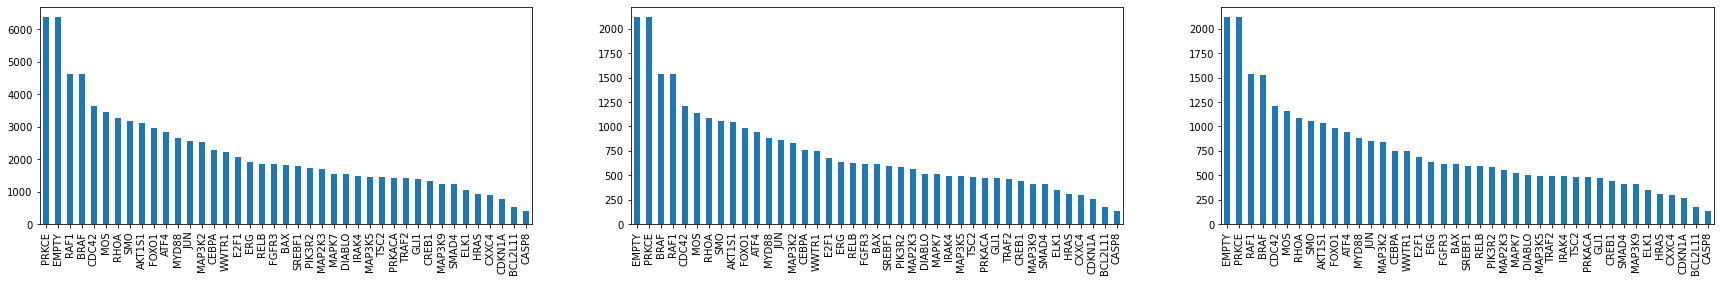

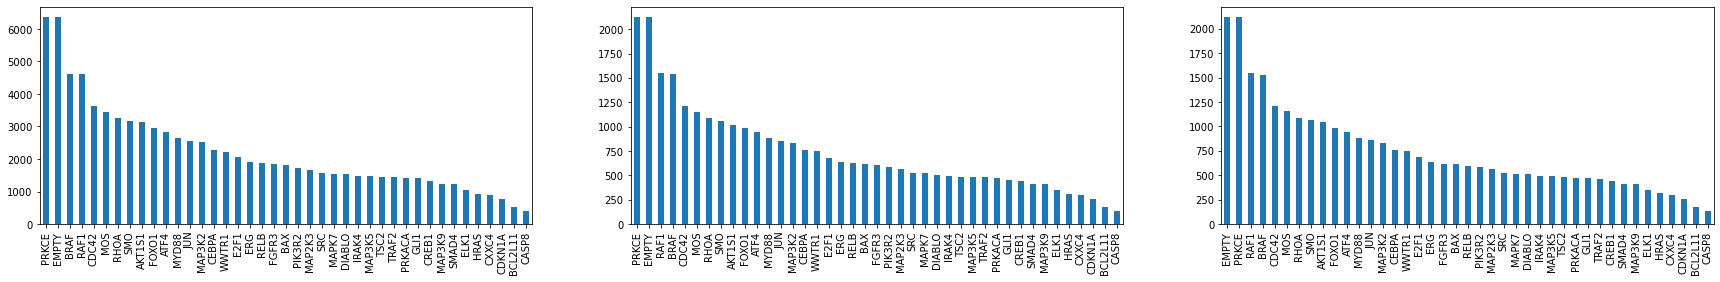

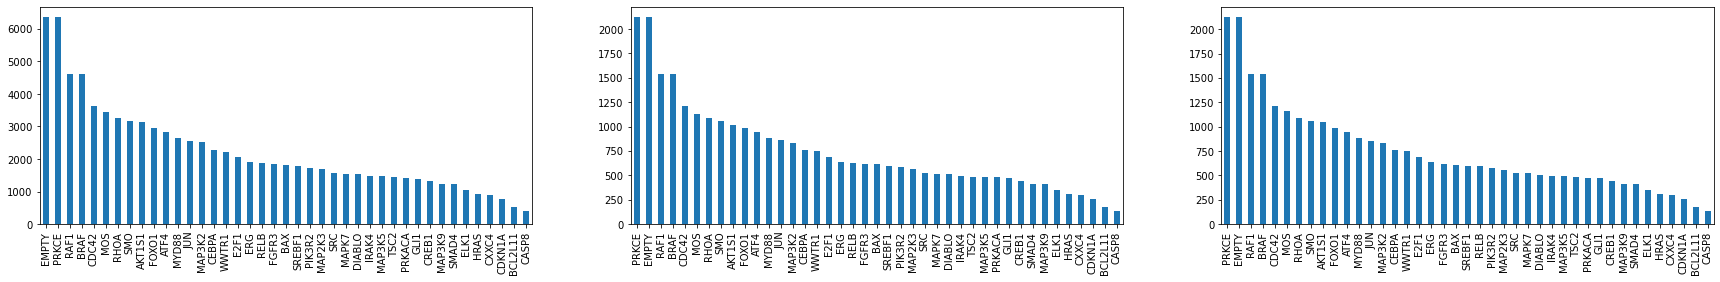

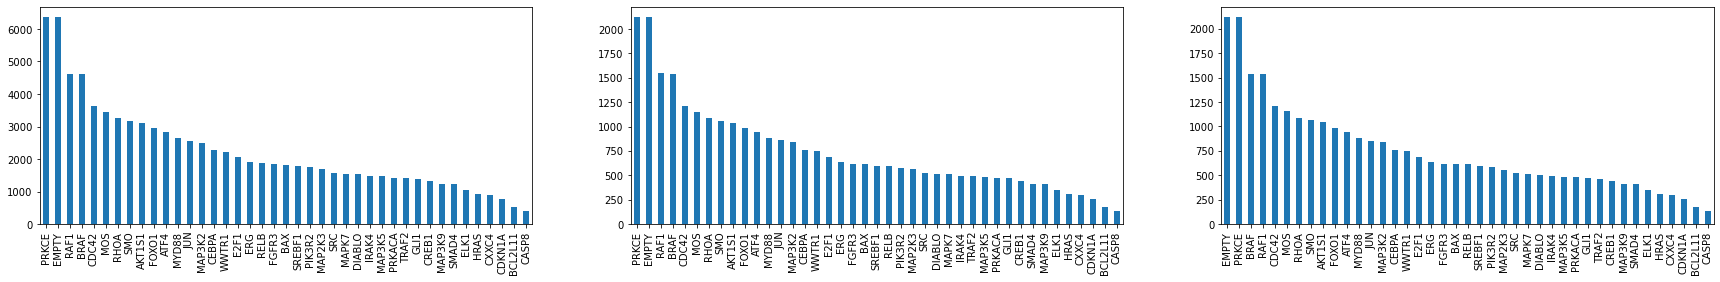

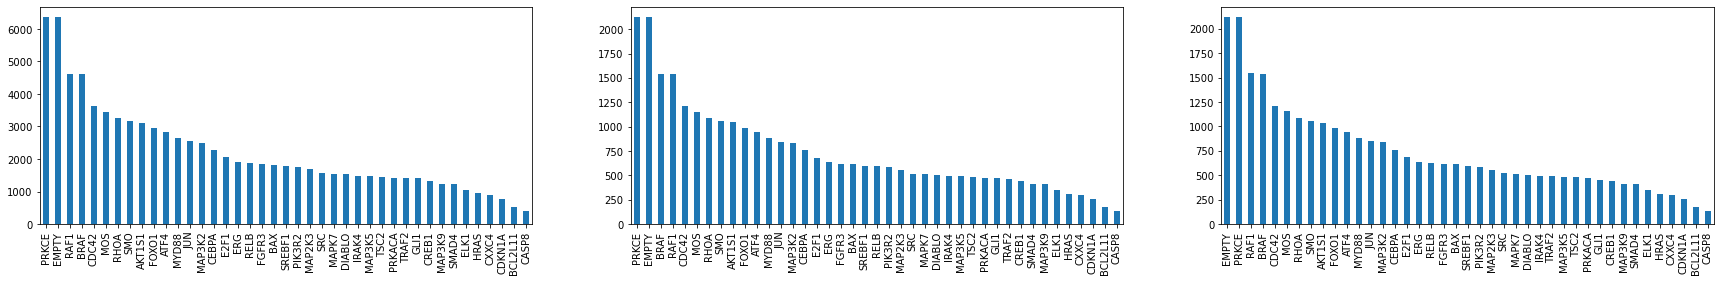

<IPython.core.display.Javascript object>

In [150]:
for i in range(len(target_list)):
    fig, ax = plt.subplots(figsize=[30, 4], ncols=3)
    ax = ax.flatten()
    loto_data["train"][i].gene_symbol.value_counts().plot(
        kind="bar", figsize=(30, 4), ax=ax[0]
    )
    loto_data["val"][i].gene_symbol.value_counts().plot(
        kind="bar", figsize=(30, 4), ax=ax[1]
    )
    loto_data["test"][i].gene_symbol.value_counts().plot(
        kind="bar", figsize=(30, 4), ax=ax[2]
    )
    plt.show()
    plt.close()

In [154]:
for i in range(len(loto_data["target"])):
    name = loto_data["name"][i]
    target_output_dir = os.path.join(output_dir, name)
    os.makedirs(target_output_dir, exist_ok=True)
    for k in ["train", "val", "test"]:
        loto_label_data = loto_data[k][i].to_csv(
            os.path.join(target_output_dir, "nuclei_md_{}_loo_{}.csv".format(name, k))
        )
    loto_data["target"][i].to_csv(
        os.path.join(target_output_dir, "nuclei_md_{}.csv".format(name))
    )

<IPython.core.display.Javascript object>